# Calibration
[OpenCV docs](https://docs.opencv.org/4.x/da/d13/tutorial_aruco_calibration.html)

In [1]:
import numpy as np
import cv2, PIL, os
from cv2 import aruco
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import pickle

%matplotlib inline

## Draw charuco board

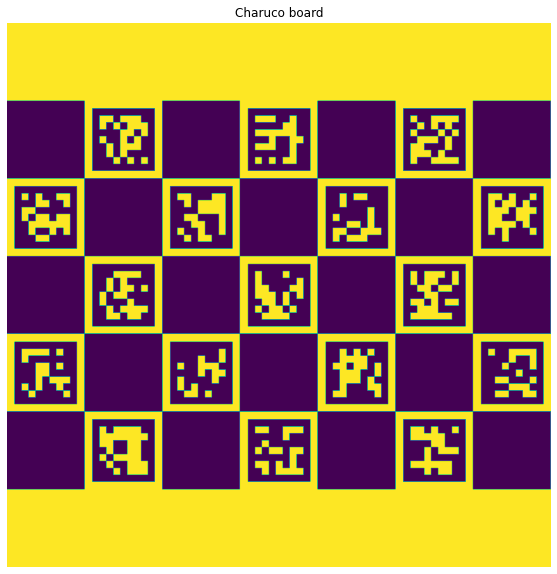

In [2]:
aruco_dict = aruco.Dictionary_get(aruco.DICT_7X7_50)
board = aruco.CharucoBoard_create(7, 5, 1, .8, aruco_dict)
imboard = board.draw((2000, 2000))
# cv2.imshow("image", imboard)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
plt.imshow(imboard)
plt.title('Charuco board')
ax.axis('off')

plt.show()

## Prepare data

In [3]:
datadir_L = "./calib_cam/left/"
images_L = np.array([datadir_L + f for f in os.listdir(datadir_L) if f.endswith(".png") ])
order = np.argsort([int(p.split(".")[1].split("/")[-1]) for p in images_L])
images_L = images_L[order]
print(len(images_L))
images_L

46


array(['./calib_cam/left/0.png', './calib_cam/left/1.png',
       './calib_cam/left/2.png', './calib_cam/left/3.png',
       './calib_cam/left/4.png', './calib_cam/left/5.png',
       './calib_cam/left/6.png', './calib_cam/left/7.png',
       './calib_cam/left/8.png', './calib_cam/left/9.png',
       './calib_cam/left/10.png', './calib_cam/left/11.png',
       './calib_cam/left/12.png', './calib_cam/left/13.png',
       './calib_cam/left/14.png', './calib_cam/left/15.png',
       './calib_cam/left/16.png', './calib_cam/left/17.png',
       './calib_cam/left/18.png', './calib_cam/left/19.png',
       './calib_cam/left/20.png', './calib_cam/left/21.png',
       './calib_cam/left/22.png', './calib_cam/left/23.png',
       './calib_cam/left/24.png', './calib_cam/left/25.png',
       './calib_cam/left/26.png', './calib_cam/left/27.png',
       './calib_cam/left/28.png', './calib_cam/left/29.png',
       './calib_cam/left/30.png', './calib_cam/left/31.png',
       './calib_cam/left/32.png', 

In [4]:
datadir_R = "./calib_cam/right/"
images_R = np.array([datadir_R + f for f in os.listdir(datadir_R) if f.endswith(".png") ])
order = np.argsort([int(p.split(".")[1].split("/")[-1]) for p in images_R])
images_R = images_R[order]
print(len(images_R))
images_R

46


array(['./calib_cam/right/0.png', './calib_cam/right/1.png',
       './calib_cam/right/2.png', './calib_cam/right/3.png',
       './calib_cam/right/4.png', './calib_cam/right/5.png',
       './calib_cam/right/6.png', './calib_cam/right/7.png',
       './calib_cam/right/8.png', './calib_cam/right/9.png',
       './calib_cam/right/10.png', './calib_cam/right/11.png',
       './calib_cam/right/12.png', './calib_cam/right/13.png',
       './calib_cam/right/14.png', './calib_cam/right/15.png',
       './calib_cam/right/16.png', './calib_cam/right/17.png',
       './calib_cam/right/18.png', './calib_cam/right/19.png',
       './calib_cam/right/20.png', './calib_cam/right/21.png',
       './calib_cam/right/22.png', './calib_cam/right/23.png',
       './calib_cam/right/24.png', './calib_cam/right/25.png',
       './calib_cam/right/26.png', './calib_cam/right/27.png',
       './calib_cam/right/28.png', './calib_cam/right/29.png',
       './calib_cam/right/30.png', './calib_cam/right/31.png',
  

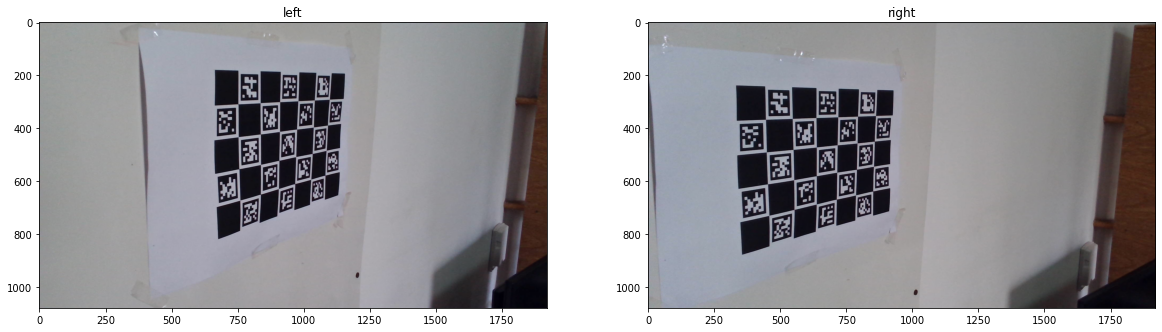

In [5]:
index = 15

im_L = PIL.Image.open(images_L[index])
im_R = PIL.Image.open(images_R[index])

fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(1,2,1)
plt.imshow(im_L)
plt.title('left')
#ax.axis('off')

ax = fig.add_subplot(1,2,2)
plt.imshow(im_R)
plt.title('right')
#ax.axis('off')

plt.show()

## Detect corners from images

In [6]:
def read_chessboards(images, aruco_dict, board):
    """
    Charuco base pose estimation.
    """
    print("POSE ESTIMATION STARTS:")
    allCorners = []
    allIds = []
    skipImgs = []
    decimator = 0

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    # objp = np.zeros(((5-1)*(7-1),3), np.float32)
    # objp[:,:2] = np.mgrid[0:(7-1),0:(5-1)].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.

    # SUB PIXEL CORNER DETECTION CRITERION
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10000000, 0.0000001)

    for im in images:
        print("=> Processing image {0}".format(im))
        frame = cv2.imread(im)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # gray = cv2.GaussianBlur(gray, (5,5), 0)

        # Documentation (https://docs.opencv.org/4.x/d9/d6a/group__aruco.html#ga061ee5b694d30fa2258dd4f13dc98129)
        corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)
        objpoint, imgpoint = cv2.aruco.getBoardObjectAndImagePoints(board, corners, ids)

        if len(corners) > 0:
            # print(f"Number of markers detected: {len(corners)}")            
            # SUB PIXEL DETECTION (https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#ga354e0d7c86d0d9da75de9b9701a9a87e)
            for corner in corners:
                cv2.cornerSubPix(gray, corner,
                                 winSize = (1,1), # The shorter the window the higher the accuracy
                                 zeroZone = (-1,-1),
                                 criteria = criteria)
            # Documentation (https://docs.opencv.org/4.x/d9/d6a/group__aruco.html#gadcc5dc30c9ad33dcf839e84e8638dcd1)
            res2 = cv2.aruco.interpolateCornersCharuco(corners, ids, gray, board)
            if res2[1] is not None and res2[2] is not None and len(res2[1])>3 and decimator%1==0:
                allCorners.append(res2[1])
                allIds.append(res2[2])
                imgpoints.append(imgpoint)
                objpoints.append(objpoint)
            else: 
                print(f"Skip image: {im}")
                skipImgs.append(im)

        else:
            print(f"Skip image: {im}")
            skipImgs.append(im)

        decimator+=1

    imsize = gray.shape

    return allCorners,allIds,imsize,skipImgs,imgpoints,objpoints

In [7]:
# allCorners,allIds,imsize,imgpoints,objpoints = read_chessboards(images, aruco_dict, board)
allCorners_L,allIds_L,imsize_L,skipImg_L,imgpoints_L,objpoints_L = read_chessboards(images_L, aruco_dict, board)
print(len(allCorners_L))
print(skipImg_L)

POSE ESTIMATION STARTS:
=> Processing image ./calib_cam/left/0.png
=> Processing image ./calib_cam/left/1.png
=> Processing image ./calib_cam/left/2.png
=> Processing image ./calib_cam/left/3.png
=> Processing image ./calib_cam/left/4.png
=> Processing image ./calib_cam/left/5.png
=> Processing image ./calib_cam/left/6.png
=> Processing image ./calib_cam/left/7.png
=> Processing image ./calib_cam/left/8.png
=> Processing image ./calib_cam/left/9.png
=> Processing image ./calib_cam/left/10.png
=> Processing image ./calib_cam/left/11.png
=> Processing image ./calib_cam/left/12.png
=> Processing image ./calib_cam/left/13.png
=> Processing image ./calib_cam/left/14.png
=> Processing image ./calib_cam/left/15.png
=> Processing image ./calib_cam/left/16.png
=> Processing image ./calib_cam/left/17.png
=> Processing image ./calib_cam/left/18.png
=> Processing image ./calib_cam/left/19.png
=> Processing image ./calib_cam/left/20.png
=> Processing image ./calib_cam/left/21.png
=> Processing imag

In [8]:
# allCorners,allIds,imsize,imgpoints,objpoints = read_chessboards(images, aruco_dict, board)
allCorners_R,allIds_R,imsize_R,skipImg_R,imgpoints_R,objpoints_R = read_chessboards(images_R, aruco_dict, board)
print(len(allCorners_R))
print(skipImg_R)

POSE ESTIMATION STARTS:
=> Processing image ./calib_cam/right/0.png
=> Processing image ./calib_cam/right/1.png
=> Processing image ./calib_cam/right/2.png
=> Processing image ./calib_cam/right/3.png
=> Processing image ./calib_cam/right/4.png
=> Processing image ./calib_cam/right/5.png
=> Processing image ./calib_cam/right/6.png
=> Processing image ./calib_cam/right/7.png
=> Processing image ./calib_cam/right/8.png
=> Processing image ./calib_cam/right/9.png
=> Processing image ./calib_cam/right/10.png
=> Processing image ./calib_cam/right/11.png
=> Processing image ./calib_cam/right/12.png
=> Processing image ./calib_cam/right/13.png
=> Processing image ./calib_cam/right/14.png
=> Processing image ./calib_cam/right/15.png
=> Processing image ./calib_cam/right/16.png
=> Processing image ./calib_cam/right/17.png
=> Processing image ./calib_cam/right/18.png
=> Processing image ./calib_cam/right/19.png
=> Processing image ./calib_cam/right/20.png
=> Processing image ./calib_cam/right/21.

### Clean up poor images

In [9]:
# clean up left (and right)

for skipImg in skipImg_L:
    index_L = np.where(images_L == skipImg)
    skipImg_right = skipImg.replace('left', 'right')
    index_R = np.where(images_R == skipImg_right)

    try:
        images_L = np.delete(images_L, index_L)
    except BaseException as e:
        print(e)

    try:
        images_R = np.delete(images_R, index_R)
    except BaseException as e:
        print(e)

print(len(images_L))
print(len(images_R))

44
44


In [10]:
# clean up right (and left)

for skipImg in skipImg_R:
    index_R = np.where(images_R == skipImg)
    skipImg_left = skipImg.replace('right', 'left')
    index_L = np.where(images_L == skipImg_left)

    try:
        images_L = np.delete(images_L, index_L)
    except BaseException as e:
        print(e)

    try:
        images_R = np.delete(images_R, index_R)
    except BaseException as e:
        print(e)

print(len(images_L))
print(len(images_R))

44
44


In [11]:
# Check
print(images_L)
print(images_R)

['./calib_cam/left/0.png' './calib_cam/left/1.png'
 './calib_cam/left/2.png' './calib_cam/left/3.png'
 './calib_cam/left/4.png' './calib_cam/left/5.png'
 './calib_cam/left/6.png' './calib_cam/left/7.png'
 './calib_cam/left/8.png' './calib_cam/left/9.png'
 './calib_cam/left/10.png' './calib_cam/left/11.png'
 './calib_cam/left/12.png' './calib_cam/left/13.png'
 './calib_cam/left/14.png' './calib_cam/left/15.png'
 './calib_cam/left/16.png' './calib_cam/left/17.png'
 './calib_cam/left/18.png' './calib_cam/left/19.png'
 './calib_cam/left/20.png' './calib_cam/left/21.png'
 './calib_cam/left/22.png' './calib_cam/left/23.png'
 './calib_cam/left/24.png' './calib_cam/left/25.png'
 './calib_cam/left/26.png' './calib_cam/left/27.png'
 './calib_cam/left/28.png' './calib_cam/left/29.png'
 './calib_cam/left/30.png' './calib_cam/left/31.png'
 './calib_cam/left/32.png' './calib_cam/left/34.png'
 './calib_cam/left/35.png' './calib_cam/left/36.png'
 './calib_cam/left/37.png' './calib_cam/left/38.png'
 '.

In [12]:
allCorners_L,allIds_L,imsize_L,skipImg_L,imgpoints_L,objpoints_L = read_chessboards(images_L, aruco_dict, board)
allCorners_R,allIds_R,imsize_R,skipImg_R,imgpoints_R,objpoints_R = read_chessboards(images_R, aruco_dict, board)

POSE ESTIMATION STARTS:
=> Processing image ./calib_cam/left/0.png
=> Processing image ./calib_cam/left/1.png
=> Processing image ./calib_cam/left/2.png
=> Processing image ./calib_cam/left/3.png
=> Processing image ./calib_cam/left/4.png
=> Processing image ./calib_cam/left/5.png
=> Processing image ./calib_cam/left/6.png
=> Processing image ./calib_cam/left/7.png
=> Processing image ./calib_cam/left/8.png
=> Processing image ./calib_cam/left/9.png
=> Processing image ./calib_cam/left/10.png
=> Processing image ./calib_cam/left/11.png
=> Processing image ./calib_cam/left/12.png
=> Processing image ./calib_cam/left/13.png
=> Processing image ./calib_cam/left/14.png
=> Processing image ./calib_cam/left/15.png
=> Processing image ./calib_cam/left/16.png
=> Processing image ./calib_cam/left/17.png
=> Processing image ./calib_cam/left/18.png
=> Processing image ./calib_cam/left/19.png
=> Processing image ./calib_cam/left/20.png
=> Processing image ./calib_cam/left/21.png
=> Processing imag

In [13]:
# Check
print("Left")
print(len(allCorners_L))
print(skipImg_L)
print("Right")
print(len(allCorners_R))
print(skipImg_R)

Left
44
[]
Right
44
[]


## Calibration

In [14]:
def calibrate_camera(allCorners, allIds, imsize, skip_images = np.array([])):
    """
    Calibrates the camera using the dected corners.
    """
    print("CAMERA CALIBRATION")

    cameraMatrixInit = np.array([[ 2000.,    0., imsize[0]/2.],
                                 [    0., 2000., imsize[1]/2.],
                                 [    0.,    0.,           1.]])

    distCoeffsInit = np.zeros((5,1))
    
    #flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL + cv2.CALIB_FIX_ASPECT_RATIO)
    flags = (cv2.CALIB_RATIONAL_MODEL + cv2.CALIB_THIN_PRISM_MODEL + cv2.CALIB_TILTED_MODEL + cv2.CALIB_FIX_ASPECT_RATIO)

    # Documentation (https://docs.opencv.org/4.x/d9/d6a/group__aruco.html#gadcc5dc30c9ad33dcf839e84e8638dcd1)
    (ret, camera_matrix, distortion_coefficients0,
     rotation_vectors, translation_vectors,
     stdDeviationsIntrinsics, stdDeviationsExtrinsics,
     perViewErrors) = cv2.aruco.calibrateCameraCharucoExtended(
                      charucoCorners=allCorners,
                      charucoIds=allIds,
                      board=board,
                      imageSize=imsize,
                      cameraMatrix=cameraMatrixInit,
                      distCoeffs=distCoeffsInit,
                      flags=flags,
                      criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10 ** 6, 1e-11))

    return ret, camera_matrix, distortion_coefficients0, rotation_vectors, translation_vectors, perViewErrors

In [15]:
print(f"Left camera")
%time ret_L, mtx_L, dist_L, rvecs_L, tvecs_L, perViewErrors_L = calibrate_camera(allCorners_L,allIds_L,imsize_L)

Left camera
CAMERA CALIBRATION
CPU times: total: 11.8 s
Wall time: 11.8 s


In [16]:
print(f"Left images with high reprojection error")

result_L = np.where(perViewErrors_L >= 1.5)
print(dict(zip(images_L[result_L[0]], perViewErrors_L[result_L[0]])))

Left images with high reprojection error
{'./calib_cam/left/4.png': array([1.61984135]), './calib_cam/left/5.png': array([1.64675142]), './calib_cam/left/6.png': array([1.80195477]), './calib_cam/left/7.png': array([1.90698549]), './calib_cam/left/8.png': array([1.61251743]), './calib_cam/left/13.png': array([1.76312248]), './calib_cam/left/15.png': array([2.02213789])}


In [17]:
print(f"Right camera")
%time ret_R, mtx_R, dist_R, rvecs_R, tvecs_R, perViewErrors_R = calibrate_camera(allCorners_R,allIds_R,imsize_R)

Right camera
CAMERA CALIBRATION
CPU times: total: 11.8 s
Wall time: 11.8 s


In [18]:
print(f"Right images with high reprojection error")

result_R = np.where(perViewErrors_R >= 1.5)
print(dict(zip(images_R[result_R[0]], perViewErrors_R[result_R[0]])))

Right images with high reprojection error
{'./calib_cam/right/3.png': array([1.89141702]), './calib_cam/right/4.png': array([2.0207303]), './calib_cam/right/5.png': array([2.0154023]), './calib_cam/right/6.png': array([2.04852984]), './calib_cam/right/7.png': array([1.65124694]), './calib_cam/right/13.png': array([1.5653392]), './calib_cam/right/14.png': array([1.57697405]), './calib_cam/right/15.png': array([1.84990782])}


In [19]:
print(f"Reprojection error\n Left: {ret_L}\n Right: {ret_R}")

Reprojection error
 Left: 1.0897795252907816
 Right: 1.1251959684518644


In [20]:
print(f"Calibration matrix:\n Left \n{mtx_L} \n Right \n{mtx_R}")

Calibration matrix:
 Left 
[[1.91995555e+03 0.00000000e+00 5.21086406e+02]
 [0.00000000e+00 1.91995555e+03 9.72732304e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] 
 Right 
[[2.00736992e+03 0.00000000e+00 3.92250123e+02]
 [0.00000000e+00 2.00736992e+03 9.79933607e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [21]:
print(f"Distortion coefficients:\n Left \n{dist_L.T} \n Right \n{dist_R.T}")

Distortion coefficients:
 Left 
[[ 0.02872199  0.05409076  0.009181   -0.03768428 -2.04696671  0.10130751
  -0.19892846 -1.84861569  0.07549846 -0.04250694 -0.01321436  0.01202643
   0.2043816   0.19605211]] 
 Right 
[[ 0.43446121  1.82264461  0.01085944 -0.02269227 -9.50604349  0.60023077
   0.96561333 -8.47656832  0.04751656 -0.07685501 -0.0186523   0.03829214
   0.19720747  0.32447286]]


### Clean up poor data

In [22]:
## Clean up and recalibrate

allIndex = np.unique(np.concatenate((result_L[0], result_R[0])))
allIndex = np.flip(allIndex)
allIndex

array([15, 14, 13,  8,  7,  6,  5,  4,  3], dtype=int64)

In [23]:
for i in allIndex:
    try:
        del allCorners_R[i]
        del allIds_R[i]
        del allCorners_L[i]
        del allIds_L[i]
    except BaseException as e:
        print(e)

images_L = np.delete(images_L, allIndex)
images_R = np.delete(images_R, allIndex)

print(len(allCorners_R))
print(len(allIds_R))
print(len(allCorners_L))
print(len(allIds_L))
print(len(images_L))
print(len(images_R))

35
35
35
35
35
35


In [24]:
print(f"Left camera")
%time ret_L, mtx_L, dist_L, rvecs_L, tvecs_L, perViewErrors_L = calibrate_camera(allCorners_L,allIds_L,imsize_L)

Left camera
CAMERA CALIBRATION
CPU times: total: 6.23 s
Wall time: 6.23 s


In [25]:
print(f"Left images with high reprojection error")

result_L = np.where(perViewErrors_L >= 1.5)
print(dict(zip(images_L[result_L[0]], perViewErrors_L[result_L[0]])))

Left images with high reprojection error
{'./calib_cam/left/9.png': array([1.62731701]), './calib_cam/left/10.png': array([1.61769844]), './calib_cam/left/12.png': array([1.77862408])}


In [26]:
print(f"Right camera")
%time ret_R, mtx_R, dist_R, rvecs_R, tvecs_R, perViewErrors_R = calibrate_camera(allCorners_R,allIds_R,imsize_R)

Right camera
CAMERA CALIBRATION
CPU times: total: 5.83 s
Wall time: 5.83 s


In [27]:
print(f"Right images with high reprojection error")

result_R = np.where(perViewErrors_R >= 1.5)
print(dict(zip(images_R[result_R[0]], perViewErrors_R[result_R[0]])))

Right images with high reprojection error
{}


In [28]:
print(f"Reprojection error\n Left: {ret_L}\n Right: {ret_R}")

Reprojection error
 Left: 0.949317848481387
 Right: 0.8227034124847965


In [29]:
# Reprojection error
# Only used for calibration with traditional chessboards
if False:
    mean_error = 0
    for i in range(len(objpoints)):
        imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
        # print((imgpoints[i].shape))
        # print((imgpoints2.shape))
        if imgpoints[i].shape != imgpoints2.shape:
            print(f"Not all markers detected in img {i}")
            continue
        error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
        # print(f"Error {i}: {error}")
        mean_error += error
    print( "total error: {}".format(mean_error/len(objpoints)) )

In [30]:
# Refining camera matrix and check calibration results
i=30 # select image index

# LEFT
print(images_L[i])
frame_L = cv2.imread(images_L[i])
img_undist_L = cv2.undistort(frame_L, mtx_L, dist_L, None, None)

h_L, w_L = frame_L.shape[:2]
new_mtx_L, roi_L = cv2.getOptimalNewCameraMatrix(mtx_L, dist_L, (w_L,h_L), 1, (w_L,h_L))
img_undist_fine_L = cv2.undistort(frame_L, mtx_L, dist_L, None, new_mtx_L)

# crop the image
x, y, w, h = roi_L
img_undist_fine_L = img_undist_fine_L[y:y+h, x:x+w]

# RIGHT
print(images_R[i])
frame_R = cv2.imread(images_R[i])
img_undist_R = cv2.undistort(frame_R, mtx_R, dist_R, None, None)

h_R, w_R = frame_R.shape[:2]
new_mtx_R, roi_R = cv2.getOptimalNewCameraMatrix(mtx_R, dist_R, (w_R,h_R), 1, (w_R,h_R))
img_undist_fine_R = cv2.undistort(frame_R, mtx_R, dist_R, None, new_mtx_R)

# crop the image
x, y, w, h = roi_R
img_undist_fine_R = img_undist_fine_R[y:y+h, x:x+w]

./calib_cam/left/40.png
./calib_cam/right/40.png


In [31]:
print(f"Calibration matrix:\n Left \n{mtx_L} \n Right \n{mtx_R}")
print(f"Calibration matrix - Refined :\n Left \n{new_mtx_L} \n Right \n{new_mtx_R}")

Calibration matrix:
 Left 
[[2.09815213e+03 0.00000000e+00 5.35293498e+02]
 [0.00000000e+00 2.09815213e+03 9.88574320e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] 
 Right 
[[1.93437247e+03 0.00000000e+00 5.19491645e+02]
 [0.00000000e+00 1.93437247e+03 9.92140998e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Calibration matrix - Refined :
 Left 
[[1.60882471e+03 0.00000000e+00 4.16140978e+02]
 [0.00000000e+00 1.56793286e+03 9.48322033e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] 
 Right 
[[1.40673486e+03 0.00000000e+00 3.68812884e+02]
 [0.00000000e+00 1.39546667e+03 9.43880608e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


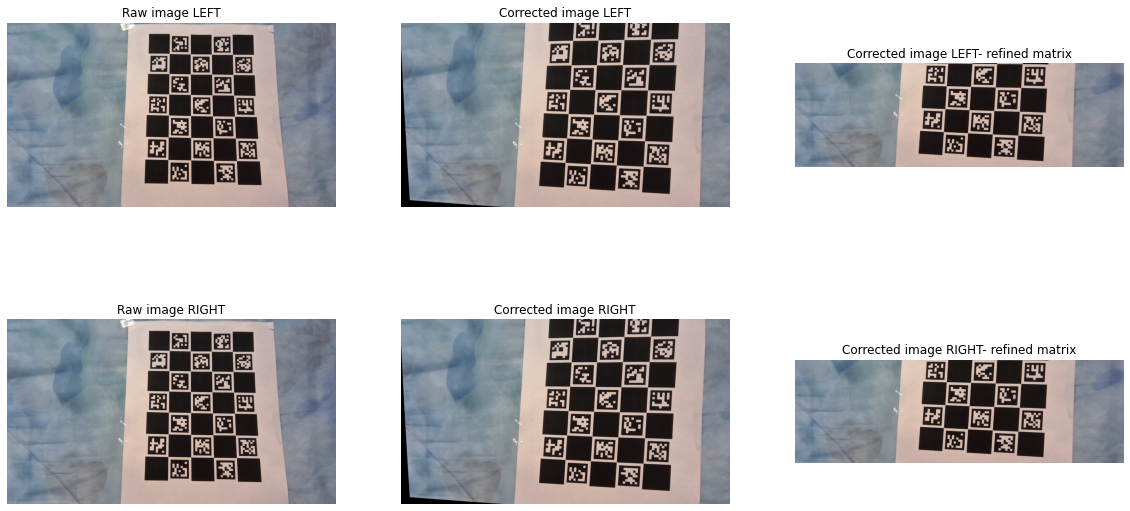

In [32]:
plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
plt.imshow(frame_L)
plt.title("Raw image LEFT")
plt.axis("off")
plt.subplot(2,3,2)
plt.imshow(img_undist_L)
plt.title("Corrected image LEFT")
plt.axis("off")
plt.subplot(2,3,3)
plt.imshow(img_undist_fine_L)
plt.title("Corrected image LEFT- refined matrix")
plt.axis("off")

plt.subplot(2,3,4)
plt.imshow(frame_L)
plt.title("Raw image RIGHT")
plt.axis("off")
plt.subplot(2,3,5)
plt.imshow(img_undist_L)
plt.title("Corrected image RIGHT")
plt.axis("off")
plt.subplot(2,3,6)
plt.imshow(img_undist_fine_L)
plt.title("Corrected image RIGHT- refined matrix")
plt.axis("off")

plt.show()

In [33]:
import pickle
import os

paramsdir = "./calib_params/"

# Check whether the specified path exists or not
isExist = os.path.exists(paramsdir)

if not isExist:
  os.makedirs(paramsdir)
  
pickle.dump(mtx_L, open('./calib_params/matrix_L.pickle', 'wb'))
pickle.dump(new_mtx_L, open('./calib_params/refined_matrix_L.pickle', 'wb'))
pickle.dump(dist_L, open('./calib_params/dist_coef_L.pickle', 'wb'))
pickle.dump(rvecs_L, open('./calib_params/rotation_vectors_L.pickle', 'wb'))
pickle.dump(tvecs_L, open('./calib_params/translation_vectors_L.pickle', 'wb'))
pickle.dump(ret_L, open('./calib_params/reprojection_error_L.pickle', 'wb'))

pickle.dump(mtx_R, open('./calib_params/matrix_R.pickle', 'wb'))
pickle.dump(new_mtx_R, open('./calib_params/refined_matrix_R.pickle', 'wb'))
pickle.dump(dist_R, open('./calib_params/dist_coef_R.pickle', 'wb'))
pickle.dump(rvecs_R, open('./calib_params/rotation_vectors_R.pickle', 'wb'))
pickle.dump(tvecs_R, open('./calib_params/translation_vectors_R.pickle', 'wb'))
pickle.dump(ret_R, open('./calib_params/reprojection_error_R.pickle', 'wb'))

### Use of camera calibration to estimate 3D translation and rotation of each marker on a scene

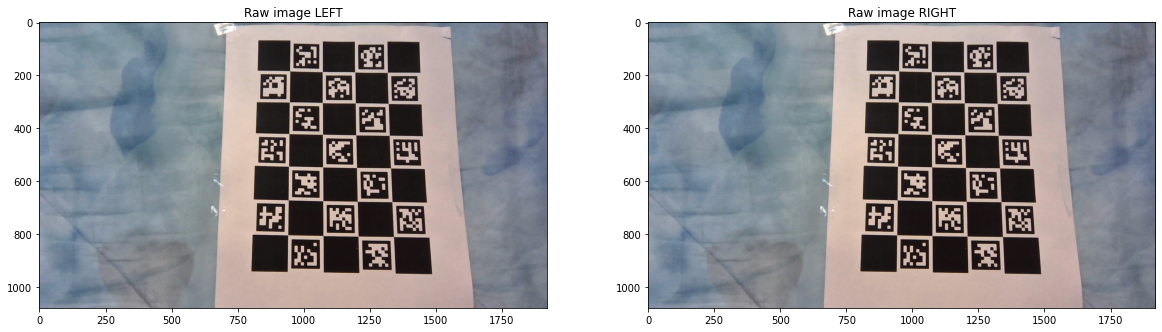

In [34]:
# frame = cv2.imread("./calib_cam_1/02_08/100.png")
#frame = cv2.undistort(src = frame, cameraMatrix = mtx, distCoeffs = dist)
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.imshow(frame_L)
plt.title("Raw image LEFT")

plt.subplot(1,2,2)
plt.imshow(frame_L)
plt.title("Raw image RIGHT")

plt.show()

In [35]:
# Post processing
parameters =  aruco.DetectorParameters_create()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.0001)

## LEFT
gray_L = cv2.cvtColor(frame_L, cv2.COLOR_BGR2GRAY)
corners_L, ids_L, rejectedImgPoints_L = aruco.detectMarkers(gray_L, aruco_dict,
                                                      parameters=parameters)
                                                                                                        
# SUB PIXEL DETECTION
for corner in corners_L:
    cv2.cornerSubPix(gray_L, corner, winSize = (1,1), zeroZone = (-1,-1), criteria = criteria)

frame_markers_L = aruco.drawDetectedMarkers(frame_L.copy(), corners_L, ids_L)

retval_L, charucoCorners_L, charucoIds_L = cv2.aruco.interpolateCornersCharuco(corners_L, ids_L, frame_L.copy(), board, cameraMatrix=new_mtx_L, distCoeffs=dist_L)
frame_corners_L = aruco.drawDetectedCornersCharuco(frame_L.copy(), charucoCorners_L, charucoIds_L)

## RIGHT
gray_R = cv2.cvtColor(frame_R, cv2.COLOR_BGR2GRAY)
corners_R, ids_R, rejectedImgPoints_R = aruco.detectMarkers(gray_R, aruco_dict,
                                                      parameters=parameters)
                                                      
# SUB PIXEL DETECTION
for corner in corners_R:
    cv2.cornerSubPix(gray_R, corner, winSize = (1,1), zeroZone = (-1,-1), criteria = criteria)

frame_markers_R = aruco.drawDetectedMarkers(frame_R.copy(), corners_R, ids_R)

retval_R, charucoCorners_R, charucoIds_R = cv2.aruco.interpolateCornersCharuco(corners_R, ids_R, frame_R.copy(), board, cameraMatrix=new_mtx_R, distCoeffs=dist_R)
frame_corners_R = aruco.drawDetectedCornersCharuco(frame_R.copy(), charucoCorners_R, charucoIds_R)

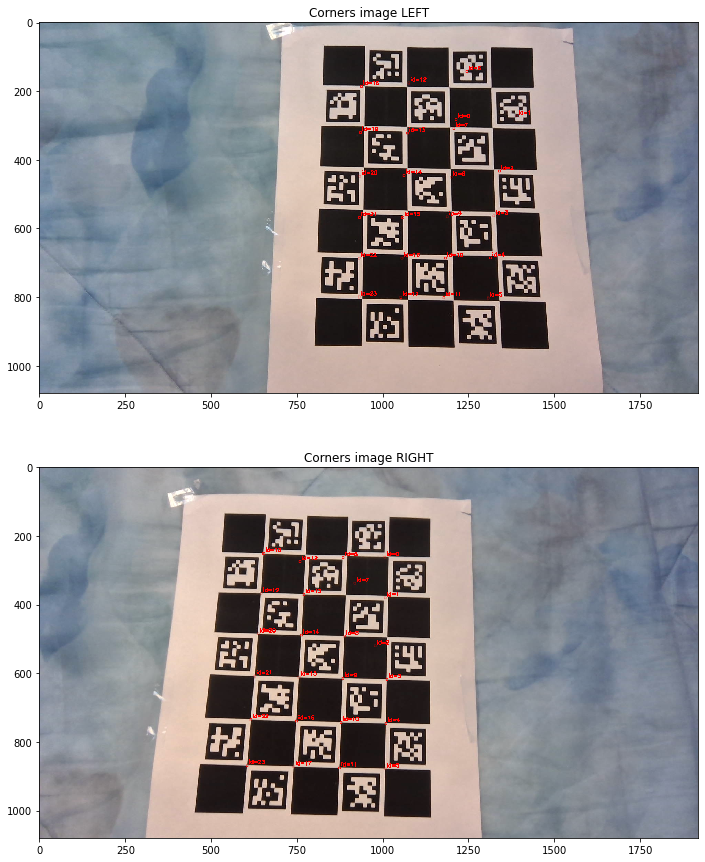

In [52]:
# Results
plt.figure(figsize=(30,15))

plt.subplot(2,1,1)
plt.imshow(frame_corners_L, interpolation = "nearest")
plt.title("Corners image LEFT")

plt.subplot(2,1,2)
plt.imshow(frame_corners_R, interpolation = "nearest")
plt.title("Corners image RIGHT")

plt.show()

Conlcusion: corner detection might be improved

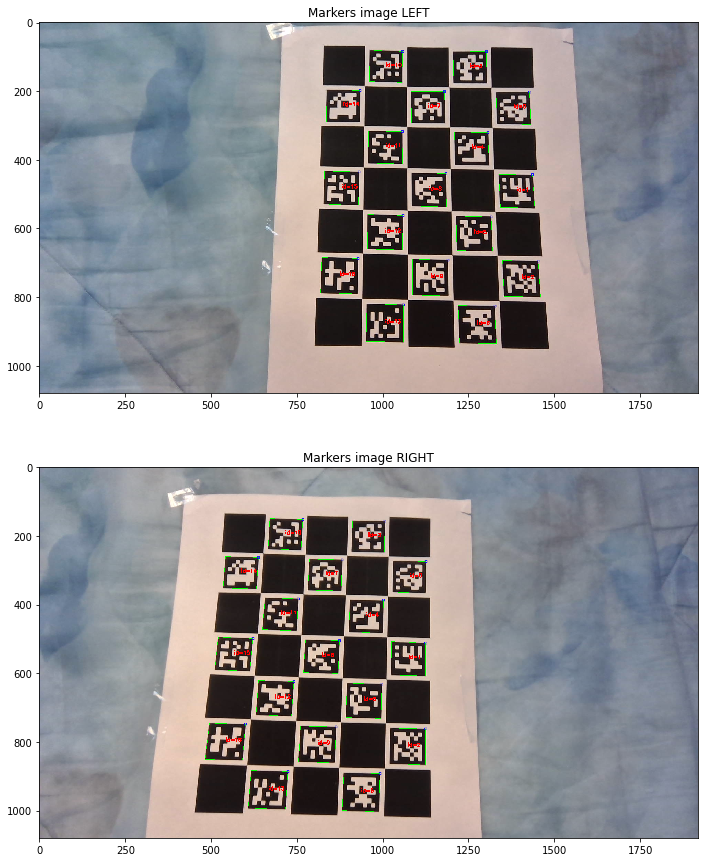

In [53]:
# Results
plt.figure(figsize=(30,15))

plt.subplot(2,1,1)
plt.imshow(frame_markers_L, interpolation = "nearest")
plt.title("Markers image LEFT")

plt.subplot(2,1,2)
plt.imshow(frame_markers_R, interpolation = "nearest")
plt.title("Markers image RIGHT")

plt.show()

### Performing stereo calibration with fixed intrinsic parameters

In [ ]:
flags = 0
flags |= cv2.CALIB_FIX_INTRINSIC
# Here we fix the intrinsic camara matrixes so that only Rot, Trns, Emat and Fmat are calculated.
# Hence intrinsic parameters are the same 

criteria_stereo = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)


# This step is performed to transformation between the two cameras and calculate Essential and Fundamenatl matrix
retS, new_mtxL, distL, new_mtxR, distR, Rot, Trns, Emat, Fmat = cv2.stereoCalibrate(obj_pts, img_ptsL, img_ptsR, new_mtxL, distL, new_mtxR, distR, imgL_gray.shape[::-1], criteria_stereo, flags)